# CSV batch processing

## Step 1: create data

In [87]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

In [37]:
def func(x, noise = False, scale = 0.05):
    """
    Data creating function.
    """
    y = np.exp(-x / 10) * np.cos(4 * x) + x/100
    z = y**2 * np.sin(5*x)
    if noise:
        y += np.random.normal(scale = 0.05, size = len(z))
        z += np.random.normal(scale = 0.05, size = len(z))
    return y, z

x = np.linspace(0., 10., 1000)
y0, z0 = func(x, noise = False)
yn, zn = func(x, noise = True)
#?np.random.normal

<IPython.core.display.Javascript object>


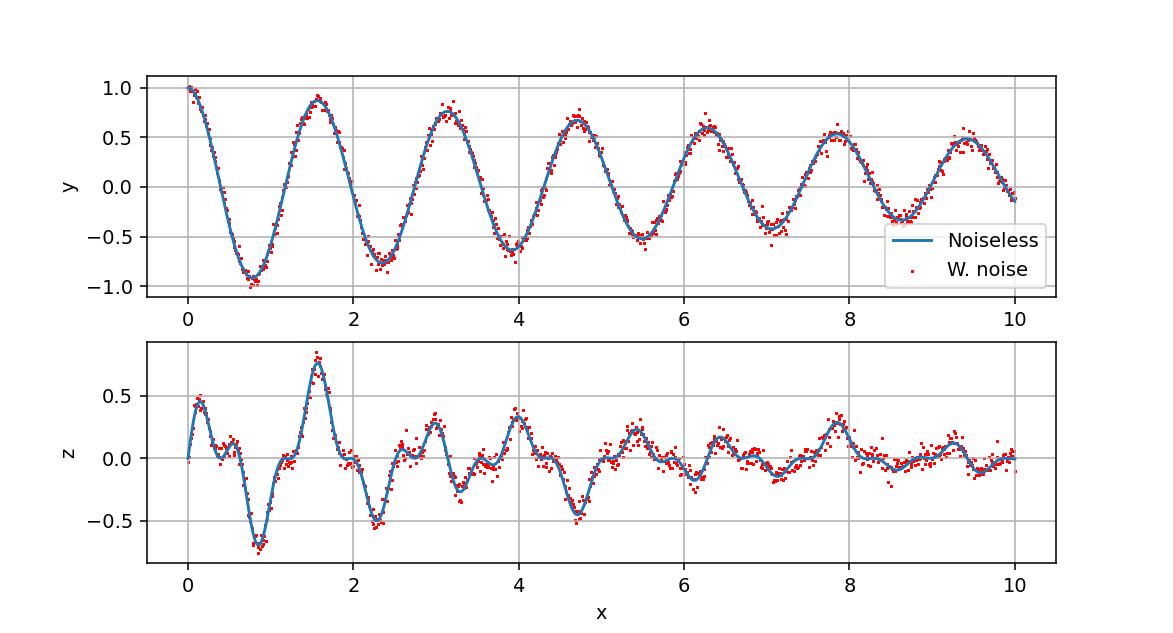

In [38]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
plt.plot(x, y0, label = "Noiseless")
plt.scatter(x, yn, label = "W. noise", marker = "+", s = 0.5, color = "red")
plt.ylabel("y")
plt.grid()
plt.legend(loc = "best")
ax2 = fig.add_subplot(2,1,2)
plt.plot(x, z0, label = "Noiseless")
plt.scatter(x, zn, label = "W. noise", marker = "+", s = 0.5, color = "red")
plt.xlabel("x")
plt.ylabel("z")
plt.grid()
plt.show()

In [45]:
def create_data(nx = 1000):
    x = np.linspace(0., 10., nx)
    y, z = func(x, noise = True)
    dic = {"x":x, "y":y, "z":z}
    df = pd.DataFrame(dic)
    return df

d = create_data()
d.head()

x         y         z
0  0.00000  0.996875  0.039570
1  0.01001  1.046519  0.055438
2  0.02002  0.965397  0.062591
3  0.03003  0.911040  0.168656
4  0.04004  0.970930  0.213298

In [46]:
d.x

0       0.00000
1       0.01001
2       0.02002
3       0.03003
4       0.04004
         ...   
995     9.95996
996     9.96997
997     9.97998
998     9.98999
999    10.00000
Name: x, Length: 1000, dtype: float64

In [54]:
import os
try:
    os.mkdir("data") # Creates a folder
except:
    print("Directory already exists, doing nothing")
d.to_csv("data/data_00.csv", index = False)

Directory already exists, doing nothing


In [62]:
# DATASET CREATION
for i in range(100):
    d = create_data()
    path = "data/data_{0}.csv".format( str(i).zfill(3) )
    d.to_csv(path, index = False)

## Step 2: Data collection

In [70]:
pathes = sorted(os.listdir("data/"))
data = [pd.read_csv("data/" + path) for path in pathes]
data = pd.concat(data, ignore_index = True)
data.head()

x         y         z
0  0.00000  1.066096 -0.076868
1  0.01001  1.011576  0.113477
2  0.02002  1.053039 -0.021763
3  0.03003  0.949482  0.146068
4  0.04004  0.941924  0.188597

In [72]:
data[data.x == 0.].head()

x         y         z
0     0.0  1.066096 -0.076868
1000  0.0  1.048020  0.012637
2000  0.0  1.017456 -0.003569
3000  0.0  1.013076  0.075749
4000  0.0  0.885587  0.058109

In [80]:
outputs = data.groupby("x").mean()
outputs.head()

y         z
x                          
0.00000  1.001699 -0.000050
0.01001  0.999644  0.043139
0.02002  0.998284  0.091722
0.03003  1.005868  0.146783
0.04004  0.979153  0.189320

<IPython.core.display.Javascript object>


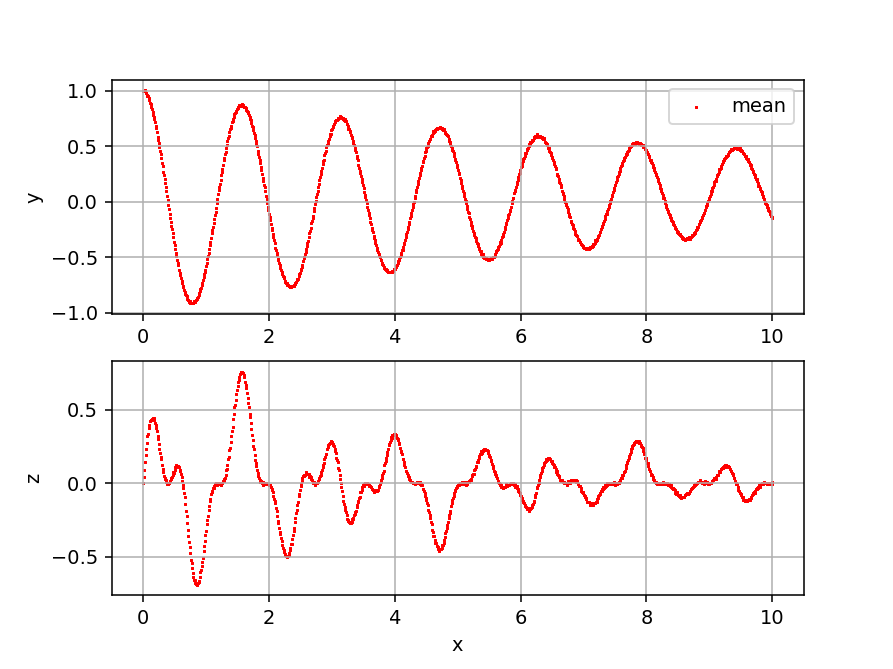

In [85]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
plt.scatter(outputs.index, outputs.y, label = "mean", marker = "+", s = 0.5, color = "red")
#plt.scatter(data.x, data.y, label = "data", marker = "+", s = 0.1, color = "blue")
plt.ylabel("y")
plt.grid()
plt.legend(loc = "best")
ax2 = fig.add_subplot(2,1,2)
plt.scatter(outputs.index, outputs.z, label = "mean", marker = "+", s = 0.5, color = "red")
plt.xlabel("x")
plt.ylabel("z")
plt.grid()
plt.show()

## Step 3: model fitting

### 3.1: with a model only on $y$

In [93]:
#from scipy import optimize

def ymodel(x, tau = 1., omega = 1.):
    y = np.exp(-x * tau) * np.cos(omega * x)
    return y

#?optimize.curve_fit
popt, pcov = optimize.curve_fit(ymodel, outputs.index, outputs.y)
tau_opt, omega_opt = popt
tau_opt, omega_opt

(0.0983922569798478, 3.9984531409560837)

<IPython.core.display.Javascript object>


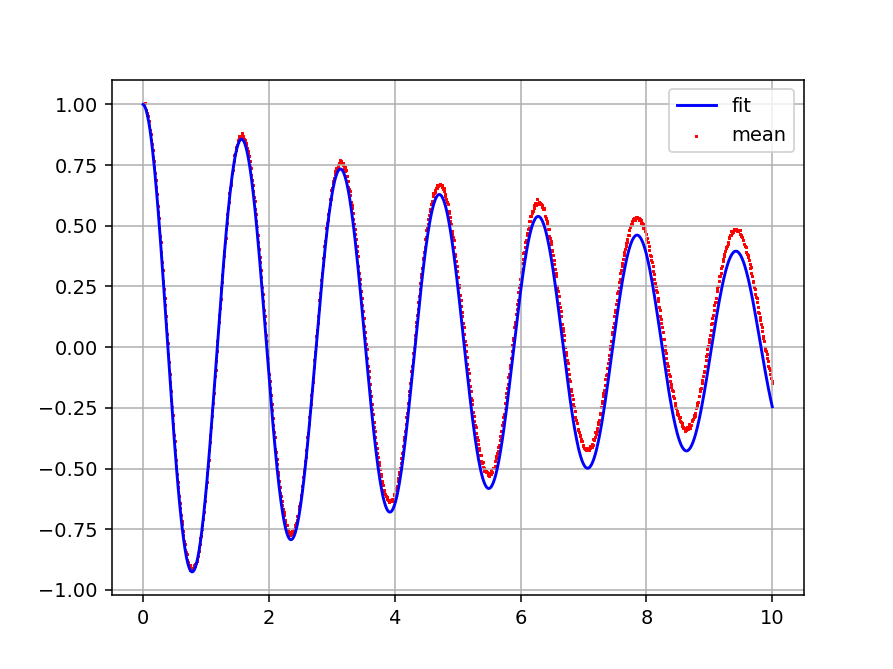

In [94]:
plt.figure()
plt.scatter(outputs.index, outputs.y, label = "mean", marker = "+", s = 0.5, color = "red")
plt.plot(outputs.index, ymodel(outputs.index, tau_opt, omega_opt), "b-", label = "fit")
plt.legend()
plt.grid()

### 3.2 With a neural network on $z$

In [182]:
import torch
layers = []
# Layer 1:
layer = torch.nn.Linear(1, 10, bias = True) #  A matrix (A * x + B)
layers.append(layer)
layers.append(torch.nn.ELU()) # Non linear rectifier
# Layer 2:
layer = torch.nn.Linear(10, 100, bias = True) #  A matrix (A * x + B)
layers.append(layer)
layers.append(torch.nn.ELU()) # Non linear rectifier
layer = torch.nn.Linear(100, 100, bias = True) #  A matrix (A * x + B)
layers.append(layer)
layers.append(torch.nn.ELU()) # Non linear rectifier
layer = torch.nn.Linear(100, 100, bias = True) #  A matrix (A * x + B)
layers.append(layer)
layers.append(torch.nn.ELU()) # Non linear rectifier
layer = torch.nn.Linear(100, 10, bias = True) #  A matrix (A * x + B)
layers.append(layer)
#layers.append(torch.nn.ELU()) # Non linear rectifier
# Layer 3:
layer = torch.nn.Linear(10, 1, bias = True) #  A matrix (A * x + B)
layers.append(layer)
#layers.append(torch.nn.ReLU()) # Non linear rectifier
model = torch.nn.Sequential(*layers)
model

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=10, out_features=100, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ELU(alpha=1.0)
  (8): Linear(in_features=100, out_features=10, bias=True)
  (9): Linear(in_features=10, out_features=1, bias=True)
)

In [183]:
import tqdm
Tx = torch.Tensor(outputs.index.values[:, None])
Tz = torch.Tensor(outputs.z.values[:, None])
learning_rate = 1.e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = torch.nn.MSELoss(reduction = "sum")
pbar = tqdm.trange(5000)
for i in pbar:
    Tzm = model(Tx)
    loss = loss_function(Tz,Tzm)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    


100%|██████████| 5000/5000 [00:27<00:00, 183.44it/s]


<IPython.core.display.Javascript object>


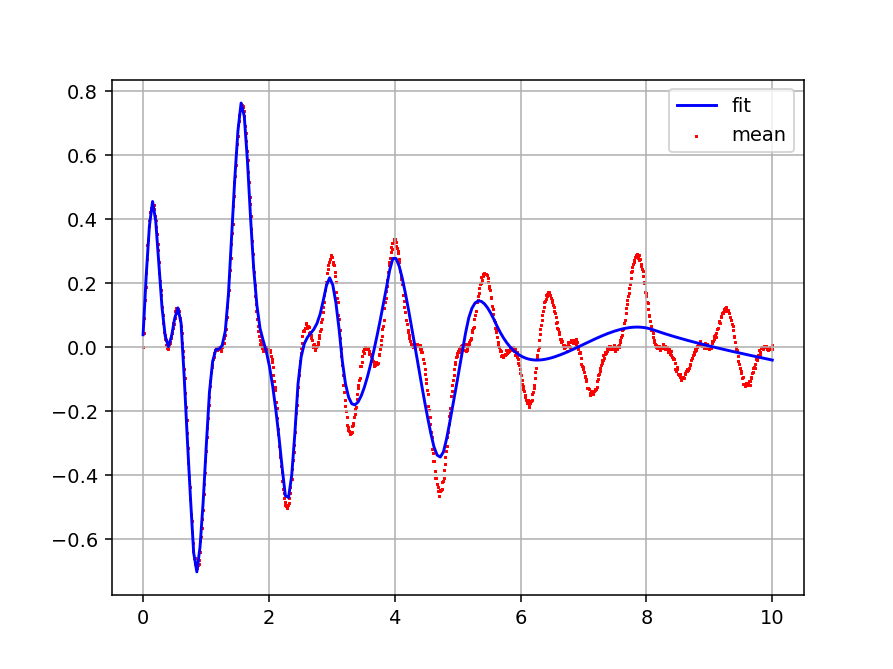

In [184]:
xtest = np.linspace(0., 10., 200)
ztest = model(torch.Tensor(xtest[:, None])).data.numpy().ravel()

plt.figure()
plt.scatter(outputs.index, outputs.z, label = "mean", marker = "+", s = 0.5, color = "red")
plt.plot(xtest,ztest, "b-", label = "fit")
plt.legend()
plt.grid()


# Examples

In [40]:
# Dictionnaries

dic = {"red": "rouge"}
dic

{'red': 'rouge'}

In [41]:
dic["red"]

'rouge'

In [42]:
dic[1] = "something"
dic

{'red': 'rouge', 1: 'something'}

In [43]:
for key, value in dic.items():
    print(key, value)

red rouge
1 something


In [60]:
# zfill

i = 20
str(i).zfill(3)

'020'